
# Futures Arbitrage



This is a research project that takes a closer look at newly introduced Solana (SOL) futures on Deribit. As the futures contracts were introduced less than 2 months ago at the time of this research there is very limited data available, however some contracts are reaching their maturity therefore providing valuable information on how efficient the market is.



## Gethering Deribit futures historical data


In [105]:
import requests
from time import sleep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import glob
from IPython.core.pylabtools import figsize
import warnings
import seaborn as sns
import json
import os
from statsmodels.graphics.tsaplots import plot_acf



%matplotlib inline
plt.style.use('ggplot')

In [6]:
import requests
from time import sleep

def download(instrument_names):
    """Downloads all past data for the provided instument names

    Parameters
    ----------
    instrument_names: iterable
        The list of instrument names to download.
    """
    #creates .txt files to stora data to optimize efficiency and time
    #This is becuse data can have up to 7million observations for BTC futures
    for name in instrument_names:
        with open(f'{name}.txt', 'w') as txt:
            txt.write('timestamp,instrument_name,price,index_price\n')
            has_more = True
            seq = 1
            count = 1000
            while has_more:
                url = f'https://test.deribit.com/api/v2/public/get_last_trades_by_instrument?instrument_name={name}&start_seq={seq}&count={count}&include_old=true'
                r = None
                for _ in range(5):
                    while r is None:
                        try:
                            r = requests.get(url, timeout=20)
                        except Timeout:
                            sleep(5)
                            pass
                r = r.json()
                for trade in r['result']['trades']:
                    timestamp = trade['timestamp']
                    instrument_name = trade['instrument_name']
                    price = trade['price']
                    index_price = trade['index_price']
                    txt.write(f'{timestamp},{instrument_name},{price},{index_price}\n')
                seq += count
                has_more = r['result']['has_more']
                
#utilizes yield function to return a generator object and save memory
def get_instrument_names(currency='BTC', kind='future'):
    """Get instrument names
    
    Parameters
    ----------
    currency: string
        The currency of instrument names to download
    kind: string
        'future' or 'option'
    expired: bool
        past instruments too or only current ones
    """
    url =f'https://test.deribit.com/api/v2/public/get_instruments?currency={currency}&kind={kind}'
    r = None
    for x in range(5):
        while r is None:
            try:
                r = requests.get(url, timeout=20)
            except Timeout:
                sleep(5)
                pass
    r = r.json()
    for instrument in r['result']:
        yield instrument['instrument_name']

#### Disclaimer:
Before running the code check where the files will be downloaded and optimally create a new folder and directory for this project!

In [ ]:
#Optional
os.getcwd()

In [ ]:
#Optional
os.chdir("")

In [41]:
#In case you want to use this as a framework there is an option to download other data
sirr = get_instrument_names("SOL", "future")
sirr

<generator object get_instrument_names at 0x7fed1eaff2e0>

In [42]:
download(sirr)

In [43]:
#Get a list of files with the historical data
#locate the folder with the downloaded .txt files
#Make sure that there are no other .txt files in this folder
files = glob.glob('//*.txt')

In [44]:
#Combine the files into one large pandas dataframe
data_list = []
for file in files:
    data = pd.read_csv(file)
    data_list.append(data)
df_futures = pd.concat(data_list)

In [45]:
#Set the index to a timestamp
df_futures['date'] = pd.to_datetime(df_futures['timestamp'], unit='ms')
df_futures.index = df_futures['date']
df_futures = df_futures.drop(columns='date')
df_futures

,timestamp,instrument_name,price,index_price
date,,,,
2021-12-10 11:50:46.807,1639137046807,SOL-PERPETUAL,197.00,179.14
2021-12-10 14:11:16.265,1639145476265,SOL-PERPETUAL,182.15,182.99
2021-12-10 14:11:19.946,1639145479946,SOL-PERPETUAL,182.15,182.99
2021-12-10 14:11:21.735,1639145481735,SOL-PERPETUAL,182.15,183.10
2021-12-10 14:41:40.559,1639147300559,SOL-PERPETUAL,182.15,182.10
...,...,...,...,...
2022-05-15 12:06:06.784,1652616366784,SOL-20MAY22,55.04,53.34
2022-05-15 12:06:06.839,1652616366839,SOL-20MAY22,55.05,53.34
2022-05-15 12:07:33.928,1652616453928,SOL-20MAY22,55.06,53.38



## Data Analysis


I am choosing the shortest maturity SOL futures available. This is to test if the selected contracts price would converge to index price as theory would suggest.

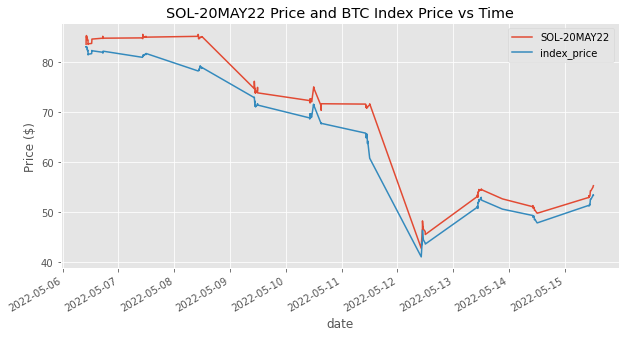

In [48]:
figsize(10, 5)
temp = df_futures[df_futures['instrument_name'] == 'SOL-20MAY22']
temp.columns = ['timestamp', 'instrument_name', 'SOL-20MAY22', 'index_price']
temp.plot(y=['SOL-20MAY22', 'index_price'])
plt.ylabel('Price ($)')
plt.title('SOL-20MAY22 Price and BTC Index Price vs Time')
plt.show()

We can see that the selected futures contract tracks the index with a noticable error and seems to very slowly converge to index price.

In [49]:
#Futures price to index price ratio
df_futures['ratio'] = df_futures['price'] / df_futures['index_price']
df_futures

,timestamp,instrument_name,price,index_price,ratio
date,,,,,
2021-12-10 11:50:46.807,1639137046807,SOL-PERPETUAL,197.00,179.14,1.099699
2021-12-10 14:11:16.265,1639145476265,SOL-PERPETUAL,182.15,182.99,0.995410
2021-12-10 14:11:19.946,1639145479946,SOL-PERPETUAL,182.15,182.99,0.995410
2021-12-10 14:11:21.735,1639145481735,SOL-PERPETUAL,182.15,183.10,0.994812
2021-12-10 14:41:40.559,1639147300559,SOL-PERPETUAL,182.15,182.10,1.000275
...,...,...,...,...,...
2022-05-15 12:06:06.784,1652616366784,SOL-20MAY22,55.04,53.34,1.031871
2022-05-15 12:06:06.839,1652616366839,SOL-20MAY22,55.05,53.34,1.032058
2022-05-15 12:07:33.928,1652616453928,SOL-20MAY22,55.06,53.38,1.031472


In [50]:
#define futures to plot
futures_names = ['SOL-20MAY22', 'SOL-27MAY22', 'SOL-24JUN22']

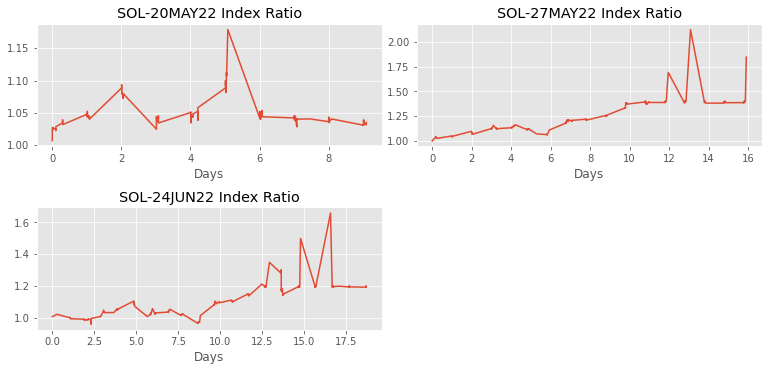

In [51]:
#Ploting the deviation from index value (1 = no deviation)
warnings.filterwarnings('ignore')
figsize(13, 9)
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i, futures in enumerate(futures_names):
    ax = fig.add_subplot(3, 2, i + 1)
    temp = df_futures[df_futures['instrument_name'] == futures]
    temp['days'] = (temp['timestamp'] - temp['timestamp'][0]) / (1000 * 60 * 60 * 24)
    ax.plot(temp['days'], temp['ratio'])
    ax.set_xlabel('Days')
    ax.set_title(f'{futures} Index Ratio')
plt.show()

An interesting observetion is the high divergence from index price of  SOL-27MAY22 futures contract as it goes against economic theory that suggests for futures contracts to converge to index price as the contract gets closer to maturity. 


### Futures Parity - test for possible arbitrage opportunities


Based on financial theory, futures price F in relation to
spot price S and risk-free rate rf; is F=S(1+rf)

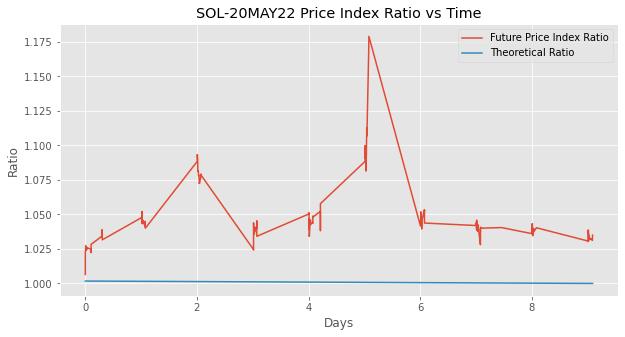

In [66]:
figsize(10, 5)
temp = df_futures.loc[df_futures['instrument_name'] == 'SOL-20MAY22',:]
temp.loc[:, 'days'] = (temp.loc[:,'timestamp'] - temp['timestamp'][0]) / (1000 * 60 * 60 * 24)

annual_rate = 0.07
daily_rate = annual_rate / 365
ys = 1 + daily_rate * (temp['days'][-1] - temp.loc[:, 'days'])
plt.xlabel('Days')
plt.ylabel('Ratio')
plt.plot(temp['days'], temp['ratio'], label='Future Price Index Ratio')
plt.plot(temp['days'], ys, label='Theoretical Ratio')
plt.legend(loc='upper right')
plt.title('SOL-20MAY22 Price Index Ratio vs Time')
plt.show()

The theoretical line shows how the futures price should move, assuming an annual simple risk free rate of 5%. Moreover, this means that whenever the theoretical line is above or below the futures price index ratio there is a possibility for arbitrage.

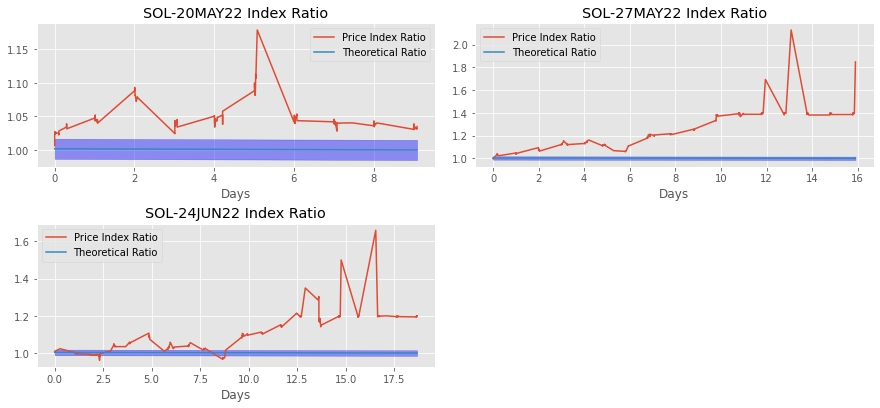

In [53]:
#adding fees to test if there is profit potential in arbitrage (1.5%)
figsize(15, 10)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.1)

annual_rate = 0.07
daily_rate = annual_rate / 365

fees = 0.015

for i, futures in enumerate(futures_names):
    ax = fig.add_subplot(3, 2, i + 1)
    temp = df_futures.loc[df_futures['instrument_name'] == futures,:]
    temp.loc[:, 'days'] = (temp.loc[:,'timestamp'] - temp['timestamp'][0]) / (1000 * 60 * 60 * 24)
    ys = 1 + daily_rate * (temp['days'][-1] - temp.loc[:, 'days'])
    #arbitrage range
    lower = ys - fees
    upper = ys + fees
    ax.plot(temp['days'], temp['ratio'], label='Price Index Ratio')
    ax.plot(temp['days'], ys, label='Theoretical Ratio')
    ax.fill_between(temp['days'], lower, upper, color='b', alpha=0.4)
    ax.set_xlabel('Days')
    ax.set_title(f'{futures} Index Ratio')
    ax.legend()
plt.show()

Theoretically, whenever the Price index Ratio is above the blue colored rectangles an arbitrage opportunity emerges. It should also be noted that fees of 1.5% are really conservative as Deribit only charges 0.05% to buy or sell a future and 0.025% on the settlement. Leaving 1.425% for other costs like slippage and costs associated to buying or selling the underlying.

Although, the results are promising the futures are most likely closely correlated and the market is efficient despite the above results.

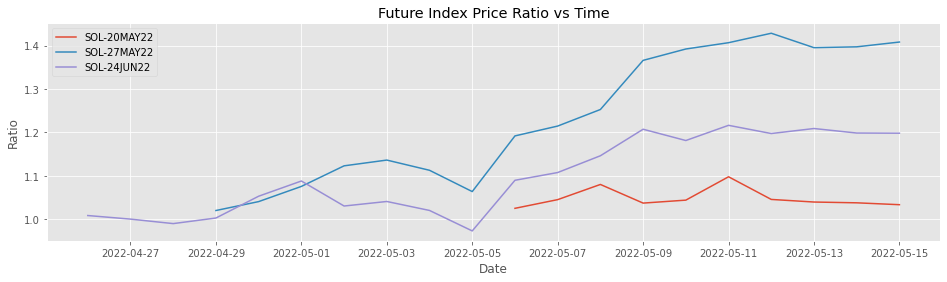

In [59]:
#Lets test if the futures contracts are closely correlated and plot the results
figsize(16, 4)
for i, futures in enumerate(futures_names):
    temp = df_futures[df_futures['instrument_name'] == futures]
    temp = temp.resample('24H').mean()
    plt.plot(temp.index, temp['ratio'], label=futures)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Future Index Price Ratio vs Time')
plt.show()

Compared to other cryptocurrencies like ETH or BTC, the correlation for SOL futures is rather low, this would imply that there are market inefficiencies and arbitrage opportunities exist for SOL futures.

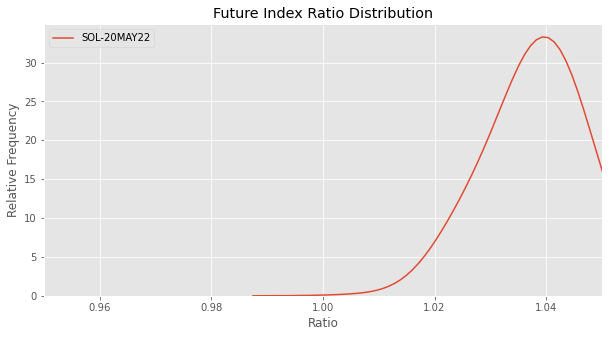

In [67]:
#Illustratring the spread
figsize(10,5)
temp = df_futures.loc[df_futures['instrument_name'] == 'SOL-20MAY22',:]
sns.kdeplot(temp['ratio'], label='SOL-20MAY22')
plt.xlabel('Ratio')
plt.ylabel('Relative Frequency')
plt.title('Future Index Ratio Distribution')
plt.xlim(0.95, 1.05)
plt.legend()   
plt.show()


As we can see from the graph which acts similarly to a histogram; the spread is really wide and for BTC and ETH futures is usually normally-distribued around the median value of 1 (for Ratio)


## Arbitrage Opportunities


Synthetic long/short positions using options as the options traded on Deribit are based on the SOL index providing direct exposure to it.
https://www.investopedia.com/articles/optioninvestor/08/synthetic-options.asp

Long/short the perpetual as the market price of the perpetual future is expected to be quite close to the index and thus can also provide bitcoin exposure. This strategy would be more optimal as it would require only a fraction of the arbitrage traded amount due to the possibility of trading on margin.


## Perpetual Futures


In [71]:
#Import the perpetual futures .txt as pandas dataframe
df = pd.read_csv('/SOL-PERPETUAL.txt')

In [72]:
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.index = df['date']
df = df.drop(columns=['timestamp', 'date'])
df.columns = ['date', 'perpetual', 'index']

In [90]:
df['ratio'] = df['perpetual'] / df['index']
df['funding'] = np.maximum(0.0005, df['ratio'] - 1) +  np.minimum(-0.0005, df['ratio'] - 1)
df

,date,perpetual,index,ratio,funding
date,,,,,
2021-12-10 11:50:46.807,SOL-PERPETUAL,197.00,179.14,1.099699,0.099199
2021-12-10 14:11:16.265,SOL-PERPETUAL,182.15,182.99,0.995410,-0.004090
2021-12-10 14:11:19.946,SOL-PERPETUAL,182.15,182.99,0.995410,-0.004090
2021-12-10 14:11:21.735,SOL-PERPETUAL,182.15,183.10,0.994812,-0.004688
2021-12-10 14:41:40.559,SOL-PERPETUAL,182.15,182.10,1.000275,0.000000
...,...,...,...,...,...
2022-05-15 23:21:21.216,SOL-PERPETUAL,58.30,58.31,0.999829,0.000000
2022-05-15 23:21:46.229,SOL-PERPETUAL,58.28,58.28,1.000000,0.000000
2022-05-15 23:22:01.222,SOL-PERPETUAL,58.26,58.22,1.000687,0.000187


In [100]:
df_D = df.resample('D').last()
df_5 = df.resample('5Min').last()

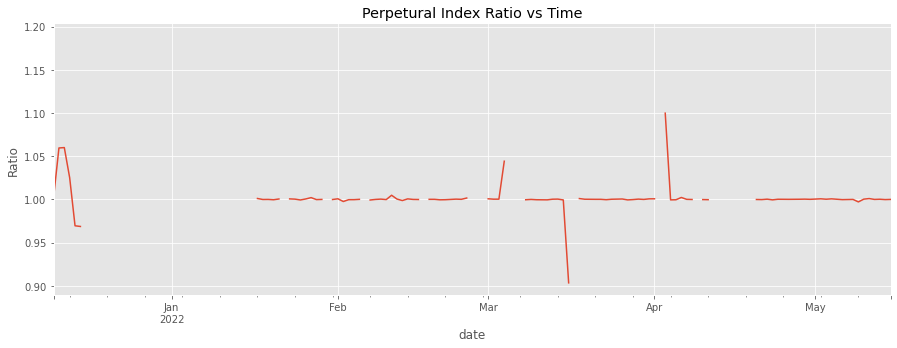

In [102]:
figsize(15,5)
df_D.plot(y='ratio', legend=False)
plt.ylabel('Ratio')
plt.title('Perpetural Index Ratio vs Time')
plt.show()

Perpetual futures are at the very least tightly correlated with the index, however there seems to be some data in discrepancies hindering the graphed results.

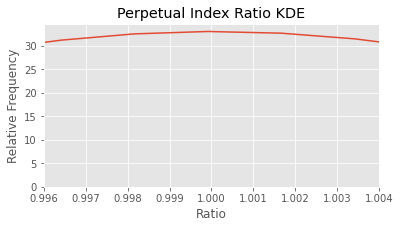

In [103]:
#distribution of values
figsize(6, 3)
sns.kdeplot(df_D['ratio'], label='Raw Data')
plt.xlabel('Ratio')
plt.ylabel('Relative Frequency')
plt.title('Perpetual Index Ratio KDE')
plt.xlim([0.996,1.004])
plt.show()

Looking at the distribution of values, the expected normal distribution with a mean value of 1 does not appear. However the difference is rather small.

## Limitations

To form any further conclusions more data on the SOL perputual futures is needed as well as a complete analysis of fees and funding rates. If the Perpetual futures will prove to be autocorrelated with the index price then they can be used to perform arbitrage with regular futures conracts. Monte Carlo simulations for different types of volatility would also be optimal as well as stress tests.